Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script

In [1]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive

In [2]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset



In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task2']
df = df.rename(columns = {"task1": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexist
1,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [5]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexist'],[0, 1])

In [6]:
#Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()
# Y revisamos como ha quedado el dataframe:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",1
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


## 2.1 - Separamos el dataset en varios conjuntos (Train, Validación y Test)

In [7]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [8]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [9]:
#Lo convertimos en un solo dataset:

TWS = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

TWS = TWS.remove_columns(["__index_level_0__"])

In [10]:
TWS

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

In [11]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['Sexista','No_Sexista']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'Sexista', '1': 'No_Sexista'}, {'Sexista': '0', 'No_Sexista': '1'})

# 3.Descarga del modelo y su tokenizador



In [12]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = 'sdadas/xlm-roberta-large-twitter'
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=128, truncation = True)

In [14]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
TWS_Encoded = TWS.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [15]:
TWS_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [16]:
#Necesitamos que los objetos sean de tipo torch
TWS_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [17]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 2, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/xlm-roberta-large-twitter and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

### 3.1.1 Métricas:

In [19]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [20]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 16
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-taskA"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
# Generamos un objeto Trainer para el entrenamiento:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = TWS_Encoded["train"],
  eval_dataset = TWS_Encoded["val"],
  tokenizer = tokenizer)

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
#5.Entrenamos nuestro modelo:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.519700,0.464430,0.792586,0.790710
2,0.341500,0.505966,0.796999,0.796559
3,0.211700,0.848842,0.797882,0.797913


TrainOutput(global_step=1701, training_loss=0.3350534882004439, metrics={'train_runtime': 2492.5619, 'train_samples_per_second': 10.908, 'train_steps_per_second': 0.682, 'total_flos': 6334570459381248.0, 'train_loss': 0.3350534882004439, 'epoch': 3.0})

# Matriz de Confusión

In [24]:
preds_output = trainer.predict(TWS_Encoded["val"])

In [25]:
preds_output.metrics

{'test_loss': 0.4644303023815155,
 'test_accuracy': 0.7925860547219771,
 'test_f1': 0.790710219487161,
 'test_runtime': 29.4663,
 'test_samples_per_second': 38.451,
 'test_steps_per_second': 2.41}

Text(0.5, 1.0, 'Matriz de confusión')

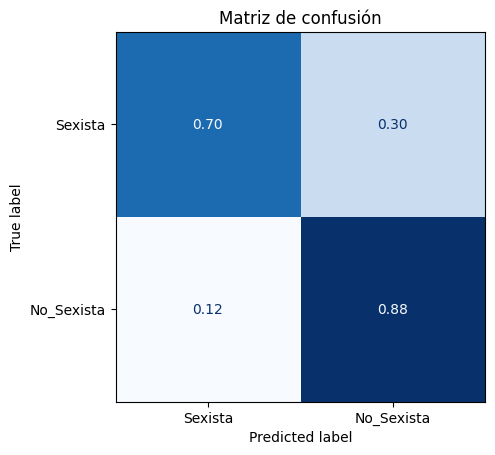

In [26]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["val"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

In [27]:
preds_output = trainer.predict(TWS_Encoded["test"])
preds_output.metrics



{'test_loss': 0.44602659344673157,
 'test_accuracy': 0.794351279788173,
 'test_f1': 0.792382841104279,
 'test_runtime': 27.9886,
 'test_samples_per_second': 40.481,
 'test_steps_per_second': 2.537}

Text(0.5, 1.0, 'Matriz de confusión')

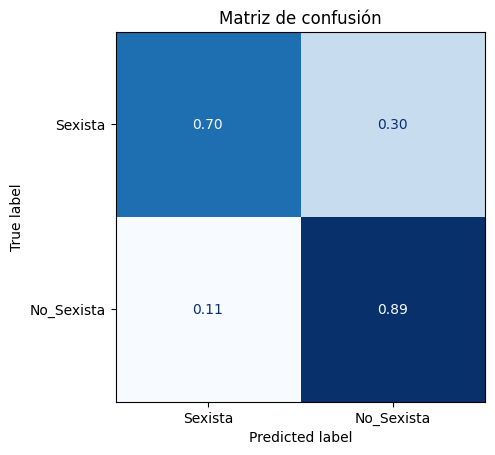

In [28]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["test"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

# Análisis del validation loss

In [29]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [30]:
TWS_Encoded["val"] = TWS_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [31]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [32]:
TWS_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = TWS_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [33]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
874,Hace un año pasé un gran día con esta pedazo mujer. ¿La veis guapa? Pues no sabéis como es por dentro... Gracias por abrirme las puertas de tu casa y por estar ahí @elisabethreyesmartin Eres una mujer maravillosa y con un gran corazón. https://t.co/JX92GREFXK,No_Sexista,Sexista,3.423573
82,@Escobarmarga si rostros capases de sacarlos a usteds de la AL por que solo mañosos hay alli maitra lagartona a la mierda el proximo Domingo,Sexista,No_Sexista,3.297390
778,"¡Epítome de la hipocresía! La propia Cynthia ha presentado cargos contra el ex ministro del interior, pero este feminazi no la defiende. Probablemente porque:Cynthia no es una mujer a sus ojos o su mentalidad líbilda se niega a creer que RM podría hacer tal cosa#patética https://t.co/jNiIAIBfe6",Sexista,No_Sexista,3.003290
349,"Me encanta ver tu cuerpo temblar cuando vas a la sobreestimulación. te conviertes en una puta desesperada para salir de nuevo. tan codicioso, pero es lindo.https://t.co/ZyiOc2744k",Sexista,No_Sexista,2.919499
494,"""Ya me divertí""""Ya no quiero juegos""Siempre es lo mismo. El alfa primero, luego el beta con dinero. #MGTOW https://t.co/Oie3CKFvuV",No_Sexista,Sexista,2.868513
179,"#NoEsBromaY como si no fuera suficiente, tendrá que pagar una pensión alimenticia ...https://t.co/5fYh13p2WO",No_Sexista,Sexista,2.850898
1056,@Rvftel así que cuando usted argumenta que sólo actuar comonan6o grado lol sólo ir a chupar en sus tetas mamá,Sexista,No_Sexista,2.840353
43,"Sí, sabemos lo borracho que era y lo que sigue siendo Killary, esperando a que su hígado se entregue.",No_Sexista,Sexista,2.784750
720,"@kaceytron todas las mujeres no hacen nada, literalmente nada... de alguna manera se las arreglan para no hacer nada literalmente todo el día salir de tu culo, dejar de quejarse de los hombres, encontrar un trabajo estable que realmente utiliza tu mente y no tu cuerpo, dejar de tratar de seguir a todos...",Sexista,No_Sexista,2.738217
163,"me da gracia este tipo de providas que además desean la muerte a las mujeres y a sus hijos, waaaaaat es que posta no logro entender a esta tontasa https://t.co/rylwmp7LzE",Sexista,No_Sexista,2.727594


In [34]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
# Ordena y muestra las primeras 10 filas
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
187,"¡ EL COMPROMISO DE HACER MEJOR !Hoy se celebra el día Internacional de Voluntariado, es por ello que quiero saludar muy afectuosamente a todos los hombres y mujeres, que forman parte de las ONG's de la Provincia, que trabajan en la emergencia. https://t.co/YD8lXuDDBG",Sexista,Sexista,0.007715
400,Hola mamitaaEspero estos días disfrutes mucho los tuits diarios que te pondré y te lleguen a sacar una sonrisa. Eres una persona muy linda que he visto a lo largo de este año como te superas y cumples cada una de tus metas. Gracias por permitirme acompañarte en este año.,Sexista,Sexista,0.008225
787,"#PixarSoul es arte: es abstracta y sencilla a la vez, en momentos divertida y dulce, en momentos ácida y triste. Un viaje emocional y emocionante que sin duda merece el reconocimiento de mejor película de animación de este año.",Sexista,Sexista,0.009242
905,"Es seguro decir que 2020 fue un año de gran importancia histórica. ¡Gracias por compartir la esperanza que nos dio Jesucristo para ayudar a estos hombres, mujeres y niños a hacer sus propias historias! Disfrute de nuestro Informe Anual de 2020 a continuación. #HistoryInTheMakinghttps://t.co/33UoegDbZ5 https://t.co/NzTleNfLTv",Sexista,Sexista,0.010289
1019,Quito merece ser lo que fue. Recuperémoste la libertad y el trabajo para rescatar a la ciudad del abandono y la desidia. La @CorteConstEcu debe devolver a lo s quiteños sus derechos. #TrabajoYLibertad #DerechosYTrabajo https://t.co/qIue7KS0Gh,Sexista,Sexista,0.011492
393,Resulta que hoy es el día de la juventud y no me queda más que felicitar al único que lo merece. Feliz día Gai! que la llama de tu juventud nunca se apague :),Sexista,Sexista,0.011831
820,"Si sales y haces que las cosas buenas sucedan, llenarás de esperanza al mundo y a tú mismo – Barack Obama¿Y si lo intentas?Atrévete, visítanos en https://t.co/QLH9voSqjV#Sanaccion #BarackObama #bueno #esperanza #mundo #Felicidad #Iluminación #Empoderamiento #crecimiento https://t.co/4YArmCNvr7",Sexista,Sexista,0.013520
940,"@StanDosComicos Poco a poco Totò, no es para nada fácil. Yo perdí a mi padre hace 8 años y he aprendido a vivir sin él, sin embargo, no hay un día q no lo piense, ese es un amor eterno.Deja atrás los errores Apa xq nadie es perfecto, valora su legado y su obra, uds hombres y mujeres de bien",Sexista,Sexista,0.013892
377,"@CoronelHMejia Mi Coronel. Para sumerced y todos los suyos una Feliz Navidad, mucha salud y prosperidad infinita. Dios Todopoderoso sabe que Ud es un buen hombre, lo que tanto necesita nuestra patria.",Sexista,Sexista,0.014078
327,"Todo el mundo, por favor escuchen, estoy enamorado de Changbin, tengo un gran enamoramiento gordo en Changbin /hj",Sexista,Sexista,0.014496


In [35]:
model.save_pretrained(
  os.path.join(path_model, 'sdadas/tareaA'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'sdadas/tareaA'))

('/content/drive/MyDrive/sdadas/tareaA/tokenizer_config.json',
 '/content/drive/MyDrive/sdadas/tareaA/special_tokens_map.json',
 '/content/drive/MyDrive/sdadas/tareaA/sentencepiece.bpe.model',
 '/content/drive/MyDrive/sdadas/tareaA/added_tokens.json',
 '/content/drive/MyDrive/sdadas/tareaA/tokenizer.json')